In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.express as px

pd.options.plotting.backend = 'plotly'
sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [3]:
fraud_data = pd.read_csv('./Fraud.csv').drop(columns=['nameOrig', 'nameDest'])

### 1) Approaching the problem

#### 1.1) Initial Thoughts

As I don't have any expertise in the financial field, I can't exactly understand all of the features taking place in this dataset, but I can try to understand them by reading the documentation, and see if any features particularly stand out to me.

**step** - A couple of features that particularly stand out to me are the `step` feature, which measures one hour of time, and the steps go from 1 to 744, logging what hour the datum is appearing from. *exclude*

**type** - This is a categorical variable, and describes what type of transaction took place, such as `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, and `TRANSFER`. These can be added into the pipeline for one-hot encoding. *include*

**amount** - The total amount of money transferred in the transaction *include*

**nameOrig** - The name of the customer who originated the transaction, *could be useful* if one of the customers is a known fraudster

**nameDest** - The name of the customer who is the recipient of the transaction

**oldbalanceOrg** - Initial balance before the transaction *include*

**newbalanceOrg** - New balance before the transaction *include*

> Possible new feature, *oldBalance - newBalance* = *balanceOrgDifference*

**oldbalanceDest** - The initial balance of the recipient before the transaction

**newbalanceDest** - The new balance of the the recipient after the transaction

> Possible new feature, *oldbalanceDest - newbalanceDest* = *balanceDestDifference*

### Target **isFraud** - 1 for fraud and 0 for non-fraud. The basis of the fraud in this simulation is that the agent aims to take control of the customer's account and empty the funds to another account and then cashing out the system

**isFlaggedFraud** - Whether the transaction was flagged as fraud, happens to transactions over 200,000


In [4]:
# Displaying the # of rows, and the # of columns we are working with in this dataset, so we have 10 features, and 1 target variable, and since we are attempting to classify whether a transaction is fraud or not, we are treating this as a classification problem.
fraud_data.shape

(6362620, 9)

In [5]:
# Gathered categorical features from the dataset
categorical_features = fraud_data.select_dtypes(include=['object'])

# Gathered numerical features from the dataset
numerical_features = fraud_data.select_dtypes(include=['int64', 'float64'])

In [6]:
categorical_features.columns, numerical_features.columns

(Index(['type'], dtype='object'),
 Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
        'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
       dtype='object'))

In [7]:
numerical_features.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [8]:
categorical_features.describe().T

,count,unique,top,freq
type,6362620,5,CASH_OUT,2237500


In [9]:
numerical_features.isnull().sum(), categorical_features.isnull().sum()

(step              0
 amount            0
 oldbalanceOrg     0
 newbalanceOrig    0
 oldbalanceDest    0
 newbalanceDest    0
 isFraud           0
 isFlaggedFraud    0
 dtype: int64,
 type    0
 dtype: int64)

In [10]:
numerical_features.isnull().sum(), categorical_features.isnull().sum()

(step              0
 amount            0
 oldbalanceOrg     0
 newbalanceOrig    0
 oldbalanceDest    0
 newbalanceDest    0
 isFraud           0
 isFlaggedFraud    0
 dtype: int64,
 type    0
 dtype: int64)

#### Observing the data, we can see that there are no null values, and some numerical features may be better off categorizing (such as step).

## 2) Data Visualization + EDA

In [11]:
# As we can see from this data, the amount has a high standard deviation, so it is generally not a normalized data, and has many outliers, and is non-normalized, to normalize it, we can log the data.
numerical_features['amount'].describe().apply(lambda x: format(x, 'f'))

count     6362620.000000
mean       179861.903549
std        603858.231463
min             0.000000
25%         13389.570000
50%         74871.940000
75%        208721.477500
max      92445516.640000
Name: amount, dtype: object

As we can see from this dataset, as the hours get into the later hours, we notice a larger amount of money being transferred. This may contribute into when fraud is more prevalent. We can further analyze this to determine what hours of the day is fraud more prevalent.

[Text(0.5, 0, 'Day'),
 Text(0, 0.5, 'Amount of Fraud'),
 Text(0.5, 1.0, 'Fraud per 30 day period')]

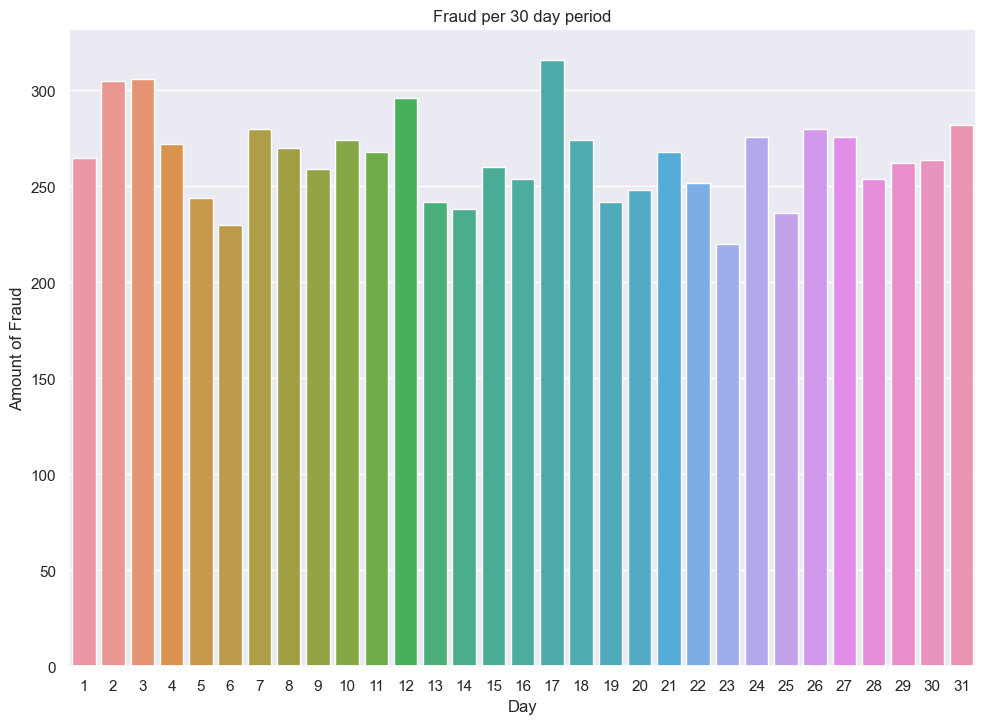

In [12]:
# The hours we will select 9pm - 3am, those are the hours we want to analyze if fraud is more prevalent during those hours. 
# Let's organize the dataset into the days, using the steps as a counter

amount_graph_data = numerical_features.copy()
amount_graph_data['day'] = (amount_graph_data['step'] // 24) + 1
amount_of_fraud_per_day = {}
days = amount_graph_data['day'].unique()

for each_day in days:
    num = len(amount_graph_data[(amount_graph_data['day'] == each_day) & (amount_graph_data['isFraud'] == 1)])
    amount_of_fraud_per_day[each_day] = num



days = list(amount_of_fraud_per_day.keys())
amounts = list(amount_of_fraud_per_day.values())

ax = sns.barplot(x=days, y=amounts)
ax.set(xlabel='Day', ylabel='Amount of Fraud', title='Fraud per 30 day period')

### As we can observe from this chart, the fraud was equally as prevalent in most of the days, but what happens when we filter it by time of day (such as at night, morning, and afternoon)

[Text(0.5, 0, 'Time of Day'), Text(0, 0.5, '# of fraud occurrences')]

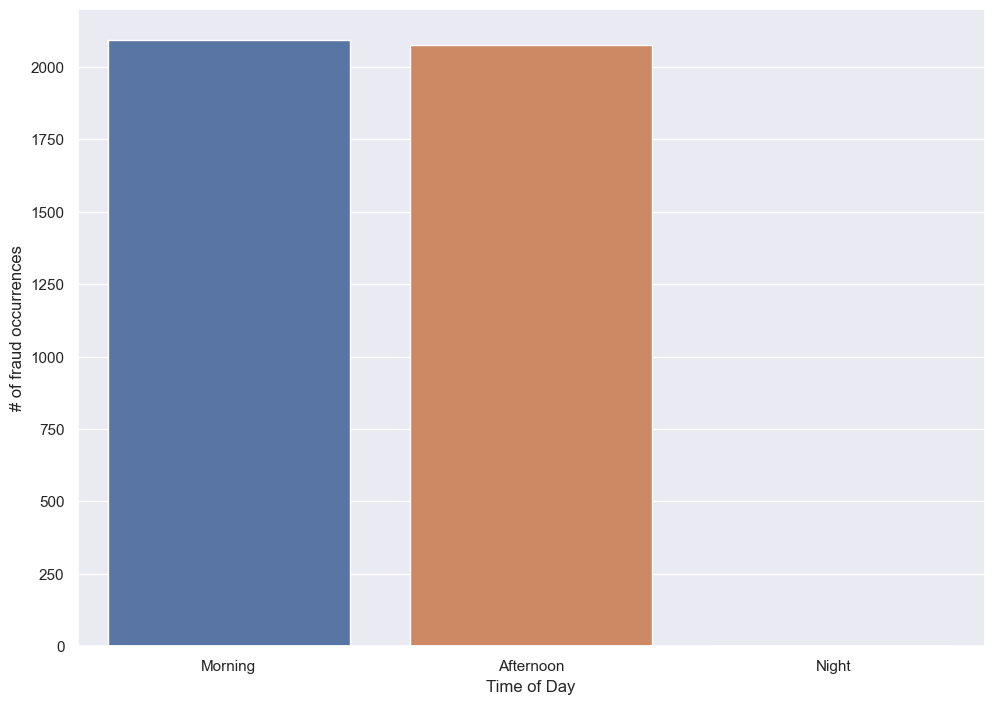

In [13]:
def add_step_time_of_day(row):
    x = row['step']
    return 0 if (x % 24) in ranges['Morning'] else 1 if (x % 24) in ranges['Afternoon'] else 2

def add_step_time_of_day_df(df):
    df_clone = df.apply(add_step_time_of_day, axis=1)
    df_clone.drop(columns=['step'])
    return df_clone


time_of_day_data = numerical_features.copy()
ranges = {
    'Morning': [6, 7, 8, 9, 10, 11],
    'Afternoon': [12, 13, 14, 15, 16, 17],
    'Night': [18, 19, 20, 21, 22, 23, 24, 0, 1, 2, 3, 4, 5],
}

time_of_day_data['time_of_day'] = time_of_day_data['step'].apply(lambda x: 0 if (x % 24) in ranges['Morning'] else 1 if (x % 24) in ranges['Afternoon'] else 2)

count = {
    'Morning': len(time_of_day_data[time_of_day_data['time_of_day'] == 0]),
    'Afternoon': len(time_of_day_data[time_of_day_data['time_of_day'] == 1]),
    'Night': len(time_of_day_data[time_of_day_data['time_of_day'] == 2])
}

fraud_per_time_of_day_count = {
    'Morning': len(time_of_day_data[(time_of_day_data['time_of_day'] == 0) & (time_of_day_data['isFraud'] == 1)]),
    'Afternoon': len(time_of_day_data[(time_of_day_data['time_of_day'] == 1) & (time_of_day_data['isFraud'] == 1)]),
    'Night': len(time_of_day_data[(time_of_day_data['time_of_day'] == 2) & (time_of_day_data['isFraud'] == 2)])
}

ax = sns.barplot(x=list(fraud_per_time_of_day_count.keys()), y=list(fraud_per_time_of_day_count.values()))

ax.set(xlabel='Time of Day', ylabel='# of fraud occurrences')

As we can see from this chart, **no fraud** ever happens during the night time, almost all fraud occurs during the morning (6am - 11am), and in the afternoon (12pm - 5pm). This means that the night time has a correlation with the fraud, the correlation is that it doesn't happen during night. Let's see the %'ages of fraud during those time frames.

In [14]:
number_of_morning = (fraud_per_time_of_day_count['Morning'] / len(time_of_day_data[time_of_day_data['time_of_day'] == 0])) * 100
number_of_afternoon = (fraud_per_time_of_day_count['Afternoon'] / len(time_of_day_data[time_of_day_data['time_of_day'] == 1])) * 100
number_of_night = (fraud_per_time_of_day_count['Night'] / len(time_of_day_data[time_of_day_data['time_of_day'] == 2])) * 100
total_fraud_count = fraud_per_time_of_day_count['Morning'] + fraud_per_time_of_day_count['Afternoon'] + fraud_per_time_of_day_count['Night']
print('fraud_count = ', total_fraud_count)
total_fraud_percentage = (total_fraud_count / len(time_of_day_data)) * 100

morning_percentage = 'Of all transactions/payments made in the morning time frame, only {:.2f}% of it is fraud'.format(number_of_morning)
afternoon_percentage = 'Of all transactions/payments made in the afternoon time frame, only {:.2f}% of it is fraud'.format(number_of_afternoon)
night_percentage = 'Of all transactions/payments made in the night time frame, only {:.2f}% of it is fraud'.format(number_of_night)
total_percentage = 'Of all transactions/payments made in the dataset, only {:.2f}% of it is fraud'.format(total_fraud_percentage)

morning_percentage, afternoon_percentage, night_percentage, total_percentage

fraud_count =  4171


('Of all transactions/payments made in the morning time frame, only 0.18% of it is fraud',
 'Of all transactions/payments made in the afternoon time frame, only 0.08% of it is fraud',
 'Of all transactions/payments made in the night time frame, only 0.00% of it is fraud',
 'Of all transactions/payments made in the dataset, only 0.07% of it is fraud')

As we can see from these percentages, only about .07% of the transactions are fraud, so the number is not that high, but considering it's part of a extremely large dataset, that means that it consists of 4171 instances of fraud, which is a considerable amount when considering that it only takes 1 fraud to completely ruin someone's financial stability, or cause chaos among the institutions. This answers our first question, which is how prevalent is fraud in the dataset, and the overall fraud rate is about .07% of transactions in the dataset.

Some questions I want to answer about this dataset:

1) How prevalent is fraud in the dataset? What is the overall fraud rate?
2) What are the characteristics associated with fraudulent transactions?
3) Are there specific features that have a high correlation with fraudulent activity?

In [15]:
numerical_features.columns, categorical_features.columns

(Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
        'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
       dtype='object'),
 Index(['type'], dtype='object'))

### Let's look at the distribution of the `type` categorical variable, and see if it has a skewed distribution, or an even distribution among the dataset, this lets us identify outliers among this variable, as well as maybe identify a correlation between the type and the fraud type

In [16]:
# sns.histplot(categorical_features['type']), 
values = pd.value_counts(categorical_features['type'])
transaction_types = ['CASH-OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT']
px.pie(values=values.to_list(), names=transaction_types, title='Total # of different types of transactions in dataset')

As we can see from this chart, the majority of transactions in the dataset comprises of CASH-OUT (obviously, because the person stealing the money wants the money in cash from the victim's account, and also PAYMENT, which means they are sending themselves the payment from the victims account or tricking the victim into sending them the money)

In [17]:
fraud_transaction_counts = pd.value_counts(fraud_data[fraud_data['isFraud'] == 1]['type'])
fraud_transaction_columns = ['CASH_OUT', 'TRANSFER']

px.pie(values=fraud_transaction_counts.to_list(), names=fraud_transaction_columns, title='Frequency of transaction type among fraudulent transactions')

As we can see from this data as well, we only have 2 types of transactions that are marked as fraud, and those are cash-out transactions and transfer transactions, let's see if we can find out how much money the average fraud transaction happens  with.

In [18]:
def compute_transferred_money(row):
    if row['type'] != 'TRANSFER':
        x = row['newbalanceDest'] - row['oldbalanceDest']
        return abs(x)
    else:
        return row['amount']
    

def compute_transferred_money_df(df):
    print(type(df))
    return df.apply(compute_transferred_money, axis=1)

In [19]:
all_fraud_transactions = fraud_data[fraud_data['isFraud'] == 1].copy()
not_fraud_transactions = fraud_data[fraud_data['isFraud'] == 0].copy()

all_fraud_transactions['total_money_transferred'] = all_fraud_transactions.apply(compute_transferred_money, axis=1)
not_fraud_transactions['total_money_transferred'] = not_fraud_transactions.apply(compute_transferred_money, axis=1)
total_cashout_money_stolen = all_fraud_transactions[all_fraud_transactions['type'] == 'CASH_OUT']['total_money_transferred'].sum()
total_transfer_money_stolen = all_fraud_transactions[all_fraud_transactions['type'] == 'TRANSFER']['total_money_transferred'].sum()
total_not_fraud_money_transferred = not_fraud_transactions['total_money_transferred'].sum()

px.pie(values=[total_cashout_money_stolen, total_transfer_money_stolen], names=['Total Cashout Money Stolen', 'Total Transfer Money Stolen'], title='Total Money Stolen by transaction type')

As we can see from this chart, the total money stolen is a even split between transfer and cash out, not one type of transaction takes the lead among money made.

In [20]:
total_fraud_money = total_transfer_money_stolen + total_cashout_money_stolen

px.pie(values=[total_fraud_money, total_not_fraud_money_transferred], names=['Total Fraud Money Stolen', 'Total Legitimate Money Transferred'], title='Total Money Stolen')

As we can see from this chart as well, the total fraud money stolen, is only about 1.51% of the total money transferred in all the transactions in the dataset. This makes it a little less concerning, knowing that the majority of the transactions that were not fraud comprised of the majority of the activity + money transferred in this dataset.

In [21]:

all_fraud_flagged_transactions = all_fraud_transactions[all_fraud_transactions['isFlaggedFraud'] == 1]
all_fraud_not_flagged_transactions = all_fraud_transactions[all_fraud_transactions['isFlaggedFraud'] == 0]

pd.value_counts(all_fraud_not_flagged_transactions['amount'])


10000000.00    284
0.00            16
1165187.89       4
429257.45        4
181.00           2
              ... 
994453.20        1
577418.98        1
407005.78        1
40611.22         1
89571.46         1
Name: amount, Length: 3964, dtype: int64

As we can see from this output, the transactions that were NOT flagged as fraud, were transferring millions of dollars to other accounts, so the business model is not performing correct when determining to flag an transaction as fraud or not, because the majority of the money transferred(stolen), are those that are not flagged as fraud, as you can see from the chart below. The total money stolen from transactions that **are** fraud consists of 0.643% of the total money stolen.

In [22]:
px.pie(all_fraud_transactions, names=['Flagged as Fraud', 'NOT Flagged as Fraud'], values=[all_fraud_flagged_transactions['total_money_transferred'].sum(), all_fraud_not_flagged_transactions['total_money_transferred'].sum()], title='Stolen money by fraudulent transaction flagging')

## 3) Preprocessing + Pipeline creation

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

transferred_money_transformer = Pipeline(steps=[("create_transferred_money", FunctionTransformer(compute_transferred_money_df))])

time_of_day_transformer = Pipeline(steps=[('time_of_day', FunctionTransformer(add_step_time_of_day_df))])

In [24]:
updated_fraud_df = fraud_data.copy()
updated_fraud_df['total_money_transferred'] = updated_fraud_df.apply(compute_transferred_money, axis=1)

In [25]:
fraud_data.select_dtypes(include=["object", "category"]).columns

Index(['type'], dtype='object')

#### 4) Preprocessing + Pipeline creation

In [26]:
X = fraud_data.drop(columns=['isFraud'])

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
transferred_money_columns = ['amount', 'newbalanceDest', 'oldbalanceDest', 'type']

preprocessor = ColumnTransformer(transformers=[
    ('tod', time_of_day_transformer, []),
    ('tm', transferred_money_transformer, []),
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='passthrough')

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

y = fraud_data['isFraud']
X_preprocessed = pipeline.fit_transform(X)

c:\Users\flyin\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



#### 5) Model Training

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(X_preprocessed, y)

def find_optimal_params(model, params, model_name):
    gscv = GridSearchCV(estimator=model, param_grid=params)
    gscv.fit(x_train, y_train)
    predictions = gscv.predict(x_test)
    score = accuracy_score(y_test, predictions)
    print(f'model = {model_name} and score = {score}, and best params = {gscv.best_params_}')

log_reg = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs')
log_reg.fit(x_train, y_train)
predictions = log_reg.predict(x_test)
score = accuracy_score(y_test, predictions)
print(f"LogisticRegression score = {score}")

random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2)
random_forest.fit(x_train, y_train)
predictions = random_forest.predict(x_test)
score = accuracy_score(y_test, predictions)
print(f"Random Forest score = {score}")

gradient_boosting = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, subsample=1.0)
gradient_boosting.fit(x_train, y_train)
predictions = gradient_boosting.predict(x_test)
score = accuracy_score(y_test, predictions)
print(f"GradientBoosting score = {score}")

xgb_classifier = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, subsample=1.0)
xgb_classifier.fit(x_train, y_train)
predictions = xgb_classifier.predict(x_test)
score = accuracy_score(y_test, predictions)
print(f"XGB score = {score}")

# models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), XGBClassifier()]
# params = [{
#     'C': [1.0],
#     'penalty': ['l2'],
#     'solver': ['lbfgs']
# }, {
#     'n_estimators': [100],
#     'max_depth': [None],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1]
# }, {
#     'learning_rate': [0.1],
#     'n_estimators': [100],
#     'max_depth': [3],
#     'subsample': [1.0]
# }, {
#     'learning_rate': [0.1],
#     'n_estimators': [100],
#     'max_depth': [3],
#     'subsample': [1.0]
# }]
# model_names = ['Logistic Regression', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'XGBClassifier']

# for ind, each_model in enumerate(models):
#     find_optimal_params(each_model, params[ind], model_names[ind])

c:\Users\flyin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression score = 0.9992248476256637


KeyboardInterrupt: 